In [47]:
# Kerakli kutubxonalar
import zipfile
import pandas as pd
import os
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from collections import Counter
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [3]:
zip_path  = '/content/multiclassificationtask.zip'
extract_folder = '/content/multiclassificationtask'


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
 zip_ref.extractall(extract_folder)

os.listdir(extract_folder)


['test.csv', 'train.csv', 'sample_submission.csv']

In [4]:
test_df = pd.read_csv('/content/multiclassificationtask/test.csv')
test_df

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,15000,22646.0,NaN,22646.0,F,NaN,NaN,NaN,N,1.4,NaN,3.34,NaN,NaN,NaN,NaN,190.0,11.0,4.0
1,15001,2149.0,NaN,18993.0,F,NaN,NaN,NaN,N,0.9,NaN,3.24,NaN,NaN,NaN,NaN,233.0,9.0,2.0
2,15002,3850.0,D-penicillamine,16050.0,M,N,N,N,N,1.0,460.0,3.64,75.0,2148.0,102.30,118.0,172.0,10.6,3.0
3,15003,2419.0,D-penicillamine,20354.0,F,N,N,N,N,0.6,258.0,3.96,31.0,642.0,70.00,83.0,336.0,10.8,2.0
4,15004,1086.0,NaN,23376.0,F,NaN,NaN,NaN,N,4.4,NaN,4.40,NaN,NaN,NaN,NaN,447.0,10.3,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,2106.0,Placebo,16728.0,F,N,N,N,N,1.1,1128.0,3.35,91.0,815.0,127.10,166.0,421.0,9.6,1.0
9996,24996,186.0,D-penicillamine,13073.0,M,N,Y,N,N,0.6,267.0,3.02,225.0,728.0,120.90,90.0,142.0,12.3,4.0
9997,24997,3458.0,D-penicillamine,20296.0,F,N,N,N,N,0.9,NaN,3.35,136.0,1995.0,128.00,NaN,243.0,10.6,2.0
9998,24998,2891.0,D-penicillamine,20254.0,F,N,N,N,N,0.8,NaN,3.75,63.0,674.0,26.35,NaN,325.0,10.0,1.0


In [60]:
train_df = pd.read_csv('/content/multiclassificationtask/train.csv')
train_df

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,2178.0,D-penicillamine,16374.0,F,N,N,N,N,0.5,263.0,3.20,43.0,1110.0,106.95,67.0,430.0,9.6,3.0,C
1,1,2644.0,D-penicillamine,17774.0,F,N,N,N,N,0.8,280.0,3.60,22.0,678.0,62.00,80.0,427.0,13.0,3.0,C
2,2,3069.0,Placebo,17844.0,F,N,N,N,N,1.1,408.0,4.40,54.0,2108.0,142.60,137.0,203.0,10.6,3.0,C
3,3,2216.0,Placebo,19221.0,F,N,Y,Y,N,0.8,252.0,3.70,36.0,843.0,55.80,56.0,336.0,9.6,4.0,C
4,4,2256.0,Placebo,21600.0,F,N,N,N,N,4.7,348.0,3.06,464.0,961.0,120.90,146.0,298.0,11.0,2.0,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,1783.0,Placebo,23107.0,F,N,Y,N,S,1.3,243.0,3.76,58.0,944.0,97.00,93.0,233.0,9.9,4.0,C
14996,14996,3492.0,NaN,13149.0,F,NaN,NaN,NaN,N,0.7,NaN,4.03,NaN,NaN,NaN,NaN,273.0,10.3,2.0,C
14997,14997,1170.0,NaN,22646.0,F,NaN,NaN,NaN,N,0.8,NaN,3.14,NaN,NaN,NaN,NaN,280.0,10.6,3.0,C
14998,14998,1433.0,Placebo,21828.0,F,N,N,N,N,0.6,280.0,4.04,52.0,843.0,28.38,189.0,334.0,10.0,2.0,C


In [7]:
train_df.shape

(15000, 20)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15000 non-null  int64  
 1   N_Days         15000 non-null  float64
 2   Drug           8494 non-null   object 
 3   Age            15000 non-null  float64
 4   Sex            15000 non-null  object 
 5   Ascites        8502 non-null   object 
 6   Hepatomegaly   8492 non-null   object 
 7   Spiders        8491 non-null   object 
 8   Edema          15000 non-null  object 
 9   Bilirubin      15000 non-null  float64
 10  Cholesterol    6701 non-null   float64
 11  Albumin        15000 non-null  float64
 12  Copper         8399 non-null   float64
 13  Alk_Phos       8488 non-null   float64
 14  SGOT           8486 non-null   float64
 15  Tryglicerides  6666 non-null   float64
 16  Platelets      14436 non-null  float64
 17  Prothrombin    14984 non-null  float64
 18  Stage 

In [61]:
train_df.describe()

,id,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,15000.000000,15000.000000,15000.000000,15000.000000,6701.000000,15000.000000,8399.000000,8488.000000,8486.000000,6666.000000,14436.000000,14984.000000,15000.000000
mean,7499.500000,1971.721267,19298.658267,1.845433,329.177302,3.526103,75.647339,1618.598233,106.483631,111.387886,252.917983,10.626111,3.024800
std,4330.271354,1333.733576,3797.580260,2.674859,180.320802,0.372268,74.830472,1767.240078,57.206017,55.056133,94.049175,0.731416,0.871303
min,0.000000,3.000000,400.000000,0.200000,120.000000,0.500000,2.000000,3.400000,0.900000,19.000000,32.000000,9.000000,1.000000
25%,3749.750000,1095.000000,16658.000000,0.600000,242.000000,3.290000,31.000000,720.000000,71.000000,80.000000,181.000000,10.100000,2.000000
50%,7499.500000,1786.000000,19544.000000,0.900000,280.000000,3.580000,52.000000,1072.000000,97.650000,99.000000,248.000000,10.600000,3.000000
75%,11249.250000,2635.000000,22347.000000,1.800000,364.000000,3.770000,89.000000,1664.000000,130.200000,133.000000,311.000000,11.000000,4.000000
max,14999.000000,38320.000000,129398.000000,28.000000,2078.000000,4.640000,662.000000,13862.400000,2653.000000,1669.000000,1024.000000,18.000000,4.000000


In [11]:
test_df.fillna(test_df.mean(numeric_only=True), inplace=True)

In [12]:
for col in test_df.select_dtypes(include='object').columns:
  test_df[col].fillna(test_df[col].mode()[0], inplace=True)

<ipython-input-12-d564644a5a09>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df[col].fillna(test_df[col].mode()[0], inplace=True)


In [15]:
print(train_df['Status'].unique())
print(test_df['Stage'].unique())

['C' 'D' 'CL' 'Y']
[4. 2. 3. 1.]


In [50]:
train_df['Status'].value_counts()

,count
Status,
C,10053
D,4565
CL,381


XGBoost  algoritmi


In [22]:
X = train_df.drop('Status', axis=1)
y_raw = train_df['Status']


le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train=X_train[y_train != 3]
y_train = y_train[y_train != 3]
X_test=X_test[y_test != 3]
y_test = y_test[y_test != 3]


In [23]:
X_train = X_train.drop('id', axis=1)
x_test = X_test.drop('id', axis=1)

In [27]:
X_train = X_train.drop(columns=['id'], errors='ignore')
X_test = X_test.drop(columns=['id'], errors='ignore')

In [28]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)


X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [51]:
# o'qitish
model.fit(X_train, y_train)

# bashorat
y_pred = model.predict(X_test)

# natija
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9108090185676393


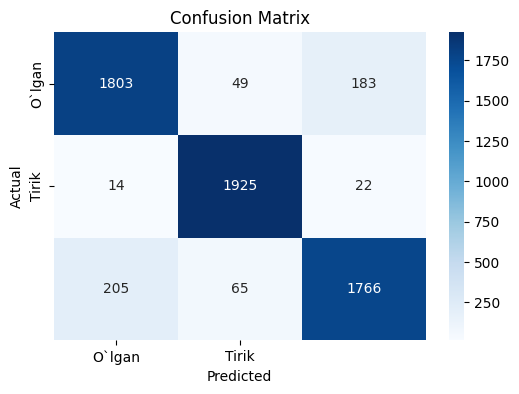

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      2035
           1       0.94      0.98      0.96      1961
           2       0.90      0.87      0.88      2036

    accuracy                           0.91      6032
   macro avg       0.91      0.91      0.91      6032
weighted avg       0.91      0.91      0.91      6032



In [52]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['O`lgan', 'Tirik'], yticklabels=['O`lgan', 'Tirik'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Natija
print(classification_report(y_test, y_pred))

 SMOTE algoritmi

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:42:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9030172413793104
Classification Report:               precision    recall  f1-score   support

           0       0.88      0.90      0.89      2035
           1       0.93      0.97      0.95      1961
           2       0.89      0.84      0.87      2036

    accuracy                           0.90      6032
   macro avg       0.90      0.90      0.90      6032
weighted avg       0.90      0.90      0.90      6032



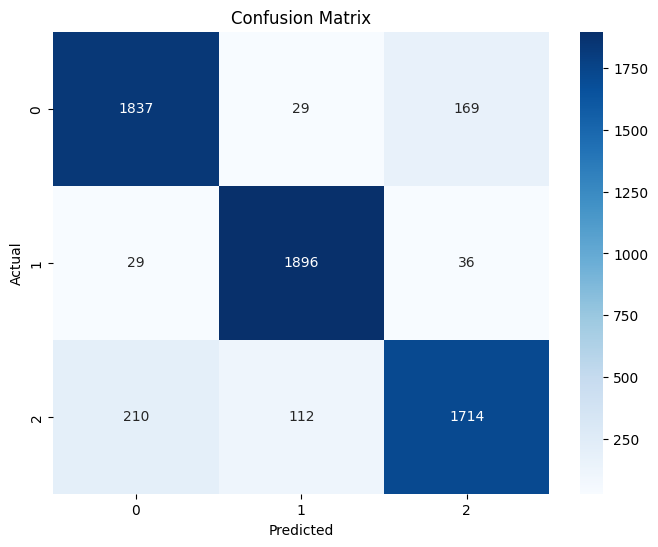

In [53]:
# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled=smote.fit_resample(X_train, y_train)

# XGBoost modelini yaratish
model = xgb.XGBClassifier(random_state=42,  use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_resampled, y_resampled)

# Test setda bashorat qilish
y_pred = model.predict(X_test)

# Natija
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:", classification_report(y_test, y_pred))


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



Logistic Regression

Accuracy: 0.729
Classification Report:               precision    recall  f1-score   support

           C       0.90      0.75      0.82      2011
          CL       0.11      0.68      0.19        76
           D       0.73      0.69      0.71       913

    accuracy                           0.73      3000
   macro avg       0.58      0.71      0.57      3000
weighted avg       0.83      0.73      0.77      3000



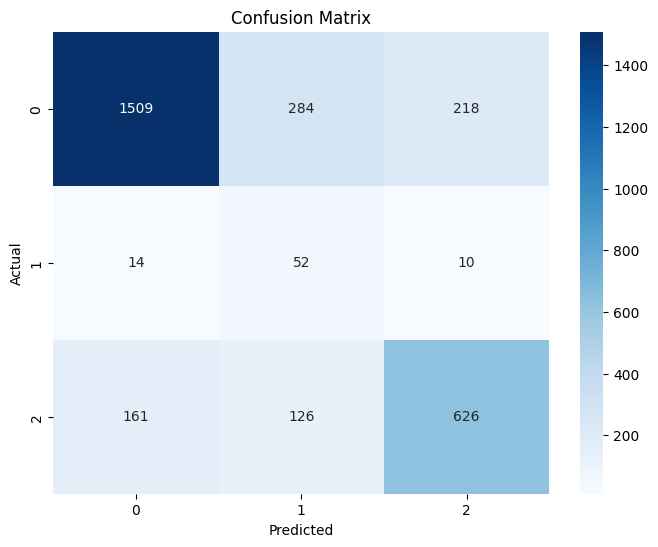

In [57]:
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


# Natija
print("Accuracy:",  (y_pred == y_test).mean())
print("Classification Report:", classification_report(y_test, y_pred))


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



SMOTE

In [48]:



y = train_df['Status']
X = train_df.drop(['Status'], axis=1)



X_numeric = X.select_dtypes(include=['float64', 'int64']).copy()


le = LabelEncoder()
y_encoded = le.fit_transform(y)


# SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_numeric, y_encoded)


# Natija
print("Oldin:", Counter(y_encoded))
print("SMOTEdan keyin:", Counter(y_resampled))




Oldin: Counter({np.int64(0): 10053, np.int64(2): 4565, np.int64(1): 381})
SMOTEdan keyin: Counter({np.int64(0): 10053, np.int64(2): 10053, np.int64(1): 10053})


Confusion matrix: [[1350   57  164]
 [   6 1582   13]
 [ 202   45 1407]]
classification report:               precision    recall  f1-score   support

           C       0.87      0.86      0.86      1571
          CL       0.94      0.99      0.96      1601
           D       0.89      0.85      0.87      1654

    accuracy                           0.90      4826
   macro avg       0.90      0.90      0.90      4826
weighted avg       0.90      0.90      0.90      4826



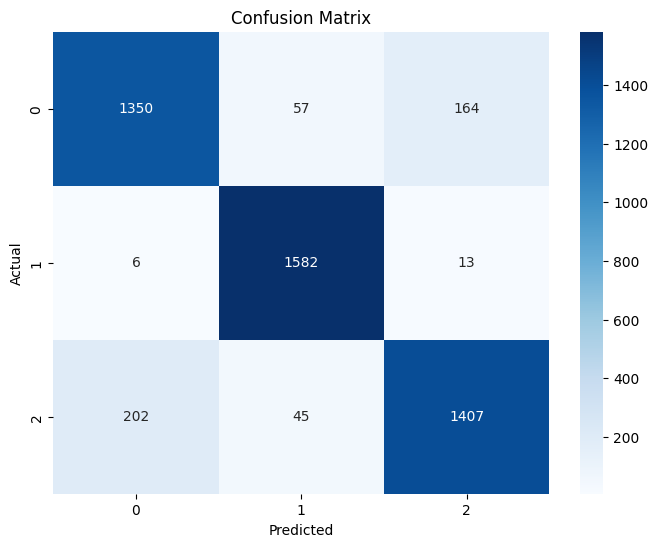

In [58]:
# Train testga ajratish
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,  test_size=0.2, random_state=42)
# Modelni yaratish va o'qitish
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)
# Bashorat
y_pred = model.predict(X_test)
# natija
print("Confusion matrix:", confusion_matrix(y_test, y_pred))
print("classification report:", classification_report(y_test, y_pred))
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()